<a href="https://colab.research.google.com/github/mchivuku/csb659-project/blob/master/symmetric_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symmetric VAE - pytorch
This is the implementation for AISTATS 2018 paper:

[Symmetric Variational Autoencoder and Connections to Adversarial Learning](https://arxiv.org/pdf/1709.01846.pdf)

In [0]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%%capture
!pip install tqdm six


In [0]:
%cd /content/drive/My\ Drive/Masters-DS/CSCI-B659/project/symmetric-vae

/content/drive/My Drive/Masters-DS/CSCI-B659/project/symmetric-vae


## Import Libraries

In [0]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.optim as optim


import os
from torchvision.utils import save_image

## Plotting library
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.gridspec as gridspec
import cv2
from scipy.stats import norm
from sklearn import manifold

plt.style.use('fivethirtyeight')
%matplotlib inline

print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
print(torch.cuda.is_available())

is_cuda = torch.cuda.is_available()
device = torch.device ( "cuda:0" if torch.cuda.is_available () else "cpu" )

Torch 1.0.1.post2 CUDA 10.0.130
Device: cuda:0
True


In [0]:
%pwd


'/content/drive/My Drive/Masters-DS/CSCI-B659/project/symmetric-vae'

## Plotting Libraries

In [0]:
## Show image
def imshow(img,title=None):
  """Imshow for Tensor."""
  img = img.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean # normalize
  img = np.clip(img, 0, 1) # clip image
  plt.figure(figsize=(16,4))
  plt.axis('off')
  plt.imshow(img)
  
  if title is not None:
    plt.title(title)         
  
def plot_grid(inputs):
  # Make a grid from batch 
  out = torchvision.utils.make_grid(inputs,10,10)
  imshow(out, title="")
  
## Visualize some images in the dataset
def visualizeDataset(X):
  for i,image in enumerate(X):
    cv2.imshow(str(i),image)
    cv2.waitKey()
    cv2.destroyAllWindows()

def plot_loss(y, title):
  plt.figure()
  plt.plot(y)
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel('Loss')
  
def plot_accuracy(y, title):
  plt.figure()
  plt.plot(y)
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  

## Scatter Plot
def scatterplot(x, y, ax, imageData, zoom):
  images = []
  imageSize = 28
  for i in range(len(x)):
    x0, y0 = x[i], y[i]
    
    # Convert to image
    img = imageData[i]*255.
    img = (img).numpy()
    img = img.astype(np.uint8).reshape([imageSize,imageSize])
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    
    # Note: OpenCV uses BGR and plt uses RGB
    image = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
    images.append(ax.add_artist(ab))
    
  ax.update_datalim(np.column_stack([x, y]))
  ax.autoscale()
  
  
import seaborn as sns
palette = np.array(sns.color_palette("hls", 10))

def plot_scatter(projection,labels):
    plt.scatter(projection[:,0], projection[:,1],c=[palette[i] for i in labels])
    
  
  
# Show dataset images with T-sne projection of pixel space
def tsne_projection_latent_space(X, image_size, display=True):
    # Compute t-SNE embedding of latent space
    
    
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X.reshape([-1,image_size*image_size*1]))

    # Plot images according to t-sne embedding
    if display:
        
        fig, ax = plt.subplots()
        scatterplot(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=0.6)
        plt.show()
    else:
        return X_tsne
      
      
# Show dataset images with T-sne projection of pixel space
def tsne_projection_latent_space2(X, Y, image_size, display=True):
    # Compute t-SNE embedding of latent space
    
    print("tsne projection of latent space...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X.reshape([-1,image_size*image_size*1]))

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots()
        plot_scatter(X_tsne, Y)
        plt.show()
    else:
        return X_tsne
      
#os.makedirs("./logs")
%ls

data/                           ngrok-stable-linux-amd64.zip.2
logs/                           ngrok-stable-linux-amd64.zip.3
ngrok*                          ngrok-stable-linux-amd64.zip.4
ngrok-stable-linux-amd64.zip    ngrok-stable-linux-amd64.zip.5
ngrok-stable-linux-amd64.zip.1  ngrok-stable-linux-amd64.zip.6


## TensorBoard Utilities

In [0]:
import tensorflow as tf
import numpy as np
import scipy.misc 
from PIL import Image 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x

## Import tensor flow library
class TensorBoardLogger(object):
  
  """
  Initialize the summary writer
  """
  def __init__(self, log_dir):
    "create summary writer"
    self.writer = tf.summary.FileWriter(log_dir)
  
  """
  Add scalar
  """
  def scalar_summary(self, tag, value, step):
    summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
    self.writer.add_summary(summary,step)
    
  """
  Add images
  """
  def image_summary(self, tag, images, step):
    """Log a list of images."""

    img_summaries = []
    for i, img in enumerate(images):
        s = BytesIO()
        
        new_p = Image.fromarray(img)
        if new_p.mode != 'L':
          new_p = new_p.convert('L')
    
        new_p.save(s, format="png")

        # Create an Image object
        img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                   height=img.shape[0],
                                   width=img.shape[1])
        # Create a Summary value
        img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

    # Create and write Summary
    summary = tf.Summary(value=img_summaries)
    self.writer.add_summary(summary, step)
        
  def histo_summary(self, tag, values, step, bins=1000):
      """Log a histogram of the tensor of values."""

      # Create a histogram using numpy
      counts, bin_edges = np.histogram(values, bins=bins)

      # Fill the fields of the histogram proto
      hist = tf.HistogramProto()
      hist.min = float(np.min(values))
      hist.max = float(np.max(values))
      hist.num = int(np.prod(values.shape))
      hist.sum = float(np.sum(values))
      hist.sum_squares = float(np.sum(values**2))

      # Drop the start of the first bin
      bin_edges = bin_edges[1:]

      # Add bin edges and counts
      for edge in bin_edges:
          hist.bucket_limit.append(edge)
      for c in counts:
          hist.bucket.append(c)

      # Create and write Summary
      summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
      self.writer.add_summary(summary, step)
      self.writer.flush()
      
      
      
import os

def make_dirs(dirname):
  if not os.path.exists(dirname):
    os.makedirs(dirname)
    
    
#make_dirs("logs")
%ls

## Logging
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
      

data/                           ngrok-stable-linux-amd64.zip.2
logs/                           ngrok-stable-linux-amd64.zip.3
ngrok*                          ngrok-stable-linux-amd64.zip.4
ngrok-stable-linux-amd64.zip    ngrok-stable-linux-amd64.zip.5
ngrok-stable-linux-amd64.zip.1  ngrok-stable-linux-amd64.zip.6
--2019-04-13 17:57:11--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.54.84.112, 35.172.177.65, 34.232.181.106, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.54.84.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.7’

ngrok-stable-linux- 100%[===================>]  14.28M  13.6MB/s    in 1.1s    

2019-04-13 17:57:12 (13.6 MB/s) - ‘ngrok-stable-linux-amd64.zip.7’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating

## Params

In [0]:
class Params:
  n_epochs = 101 ## number of epochs
  mb_size = 64 ## mini batch size 
  lr = 1e-4 ## learning rate
  Z_dim = 128 * 2
  pa, pb = 0., 0.
  lamb = 1.
  

torch.manual_seed(5)

In [0]:
def log(x):
    return torch.log(x + 1e-8)


## Data Loader

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Params.mb_size,
                                          shuffle=True, num_workers=2)


Files already downloaded and verified


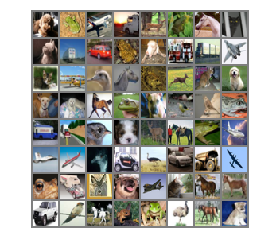

  dog  frog plane truck


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

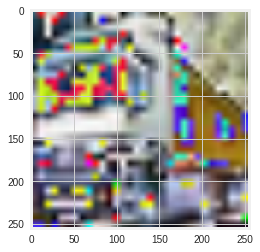

In [0]:
## print number of training examples
num_train = len(trainset)
test_image = trainset[1][0]
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
img2 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(255),
    transforms.ToTensor(),
])(test_image)
show(img2)

In [0]:
t1,t2 = (next(iter(trainloader)))
len(t1)

64

## Util Functions

In [0]:
## Sample from X and Y
def sample_XY(X, Y, size):
    start_idx = np.random.randint(0, X.shape[0] - size)
    return X[start_idx:start_idx + size], Y[start_idx:start_idx + size]

## Sample from X
def sample_X(X, size):
    start_idx = np.random.randint(0, X.shape[0] - size)
    return X[start_idx:start_idx + size]

# Sample only from Y
def sample_Y(Y, size):
    start_idx = np.random.randint(0, Y.shape[0] - size)
    return Y[start_idx:start_idx + size]

## Sample z
def sample_Z(m, n):
    return np.array(np.random.uniform(-1., 1., size=[m, n]),dtype=np.float32)


####Test

In [0]:
print("Sample z",sample_Z(3,3))
print("Sample Y",sample_Y(np.arange(10),2))
print("Sample X",sample_X(np.arange(10),2))
print("Sample XY",sample_XY(np.arange(10),np.arange(20),4))

Sample z [[ 0.75406367  0.15078302  0.61752677]
 [-0.61921424  0.7288262   0.31319785]
 [ 0.72838056 -0.7733985  -0.28735325]]
Sample Y [0 1]
Sample X [3 4]
Sample XY (array([5, 6, 7, 8]), array([5, 6, 7, 8]))


## Plots

In [0]:
def plot(samples,m = 8):
  fig = plt.figure(figsize= (m,m))
  gs = gridspec.GridSpec(m,m)
  gs.update(wspace = 0.05, hspace = 0.05)
  
  for i, sample in enumerate(samples):
    ax  = plt.subplot(gs[i])
    plt.axis("off")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect("equal")
    plt.imshow(sample)
    
  return fig


#plot([trainset[i][0] for i in range(8)])

## Models
1. Encoder 1
2. Encoder 2
3. Discriminator 1
4. Discriminator 2

### Encoder1

In [0]:
from torch.distributions import uniform

"""
Initialize weights in pytorch
"""
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class Encoder1(nn.Module):
    def __init__(self, mb_size, hidden_dim):
        super(Encoder1, self).__init__()
        
        self.hidden_dim =  hidden_dim
        #16, 16, 32
        self.conv1 = nn.Conv2d(4, 32, kernel_size=5, stride=2, padding = 2)
        self.bn1 = nn.BatchNorm2d(32)

        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=2,padding = 2)
        
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128,256,kernel_size = 5, stride = 2, padding = 2)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.fc = nn.Linear(256*2*2,self.hidden_dim)
        self.relu = nn.ReLU()
        
    
    def forward(self,x):
        distribution = uniform.Uniform(torch.Tensor([-1]),torch.Tensor([1]))
        noise = distribution.sample(torch.Size([Params.mb_size,1, 32,32]))
        noise = noise.squeeze(4)
        noise = noise.to(device)
        
        x = torch.cat([x,noise],dim = 1)
        x = self.relu(self.bn1(self.conv1(x)))
        
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        
        ## Fully connected layers
        x = x.reshape(x.size(0), -1)
        x = torch.tanh(self.fc(x))
        return x
      
Z_dim = 128*2
encoder1 = Encoder1(Params.mb_size,Z_dim)
encoder1.apply(init_weights)

if is_cuda:
  encoder1 = encoder1.to(device)
  
  
encoder1

Encoder1(
  (conv1): Conv2d(4, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
)

### Encoder2

In [0]:
# noise = tf.random_normal([mb_size, 10])
def lrelu(x, leak=0.2, name="lrelu"):
      f1 = 0.5 * (1 + leak)
      f2 = 0.5 * (1 - leak)
      return f1 * x + f2 * abs(x)
noise_dim = 20
class Encoder2(nn.Module):
    
    def __init__(self, mb_size):
        super(Encoder2, self).__init__()
        
        self.fc  = nn.Linear(276, 64 * 8 * 4 * 4)
        self.bn = nn.BatchNorm1d(64 * 8 * 4 * 4)
        
        self.deconv1 = nn.ConvTranspose2d(8 * 64 , 64 * 4, 6, stride=2,padding = 2)
        self.bn1 = nn.BatchNorm2d(64 * 4)
        
        
        self.deconv2 = nn.ConvTranspose2d(64 * 4 , 64 * 2, 6, stride=2,padding = 2)
        self.bn2 = nn.BatchNorm2d(64 * 2)
        
        self.deconv3 = nn.ConvTranspose2d(64 * 2 , 3, 6, stride=2,padding = 2)
        
        self.lrelu = lrelu
        self.relu = F.relu
        
    def forward(self,x):
        distribution = uniform.Uniform(torch.Tensor([-1]),torch.Tensor([1]))
        noise = distribution.sample(torch.Size([32*2, 20])).squeeze()
        
        x = torch.cat([x, noise.to(device)],dim = 1)
        
        x = self.relu(self.bn(self.fc(x)))
        x = x.reshape([-1, 64 * 8, 4, 4])
        

        x = self.lrelu(self.bn1(self.deconv1(x)))
        
        x = self.relu(self.bn2(self.deconv2(x)))
        
        x = torch.tanh(self.deconv3(x))

        return x

In [0]:
encoder2 = Encoder2(Params.mb_size)
encoder2.apply(init_weights)
if is_cuda:
  encoder2 = encoder2.to(device)
  
print(encoder2)

Encoder2(
  (fc): Linear(in_features=276, out_features=8192, bias=True)
  (bn): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1): ConvTranspose2d(512, 256, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(256, 128, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(128, 3, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
)


### Discriminator

In [0]:
## Discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
     
      #16, 16, 64
    self.conv1 = nn.Conv2d(4, 64, kernel_size=5, stride=2, padding = 2)
    self.bn1 = nn.BatchNorm2d(64)
      
      #8, 8 , 128
    self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2,padding = 2)
    self.bn2 = nn.BatchNorm2d(128)
      
      # 4, 4, 256
    self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2,padding = 2)
        
    self.bn3 = nn.BatchNorm2d(256)
      
      # 2, 2, 512
      
    self.conv4 = nn.Conv2d(256, 512, kernel_size=5, stride=2,padding = 2)
    self.bn4 = nn.BatchNorm2d(512)
      
      ## Linear
    self.fc1 = nn.Linear(276,2*2*512)
      
    self.fc2 = nn.Linear(4096,1)
   
  def forward(self,x,y):
    distribution = uniform.Uniform(torch.Tensor([-1]),torch.Tensor([1]))
    noise = distribution.sample(torch.Size([Params.mb_size,1, 32,32]))
    noise = noise.squeeze(4)

    h = torch.cat([x, noise.to(device)], dim=1)
    h = lrelu(self.bn1(self.conv1(h)))
    h = lrelu(self.bn2(self.conv2(h)))
    h = lrelu(self.bn3(self.conv3(h)))
    h = lrelu(self.bn4(self.conv4(h)))
    h = h.view(-1,2048)
    noise_z = distribution.sample(torch.Size([Params.mb_size,20])).squeeze().to(device)
    y = torch.cat([y,noise_z],dim=1)
    
    zh = lrelu(self.fc1(y))
    h = torch.cat([h, zh], dim=1)

    h = (self.fc2(h))

    return h, torch.sigmoid(h)
      
      
  
discriminator = Discriminator()
discriminator.apply(init_weights)
if is_cuda:
  discriminator = discriminator.to(device)
  
  
print(discriminator)

Discriminator(
  (conv1): Conv2d(4, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=276, out_features=2048, bias=True)
  (fc2): Linear(in_features=4096, out_features=1, bias=True)
)


In [0]:
## conv conditional concat
def conv_cond_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.size()
    y_shapes = y.size()
    return torch.cat([
        x, y * torch.ones([x_shapes[0], x_shapes[1], x_shapes[2], y_shapes[3]])], 3)


In [0]:
## Z dimension -> X
def generative_Y2X(z, reuse=None):
    h = encoder2(z)
    return h
  
## Encode - X -> latent representation Z
def generative_X2Y(x, reuse=None):
    h = encoder1(x)
    return h

In [0]:
def data_network(x, y, reuse=None):
    f, d = discriminator(x, y)
    return f.squeeze(1), d.squeeze(1)

In [0]:
N =  Params.mb_size
X = torch.randn(N, 3, 32, 32, device=device)
z = torch.randn(N, Z_dim, device=device)
z_gen = generative_X2Y(X)
y_gen = generative_Y2X(z)
fxz, Dxz = data_network(X, z_gen)
fzx, Dzx = data_network(y_gen, z)

In [0]:
## Discriminator Loss 

D_loss = torch.mean(torch.log(Dzx) - torch.log(1- Dxz))

## Generator Loss
L_x = -torch.mean((fxz))
L_z = torch.mean(fzx)

## Total Generator Loss
G_loss = L_x + L_z

print(G_loss)

tensor(0.1937, device='cuda:0', grad_fn=<AddBackward0>)


In [0]:
## Reconstruction
X_rec = generative_Y2X(z_gen)
z_rec = generative_X2Y(y_gen)

In [0]:
X_rec_loss = torch.mean(torch.abs(X-X_rec))
Z_rec_loss = torch.mean(torch.abs(z-z_rec))

In [0]:
print(X_rec_loss,Z_rec_loss)

tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8594, device='cuda:0', grad_fn=<MeanBackward1>)


In [0]:
G_solver = optim.Adam(list(encoder1.parameters()) + list(encoder2.parameters()), lr= Params.lr,betas =[0.5,0.5])
D_solver = optim.Adam(discriminator.parameters(), lr= Params.lr, betas =[0.5,0.5])


## Training

epoch: 0, iteration: 0, D_loss: 0.2822; G_loss: -1.824


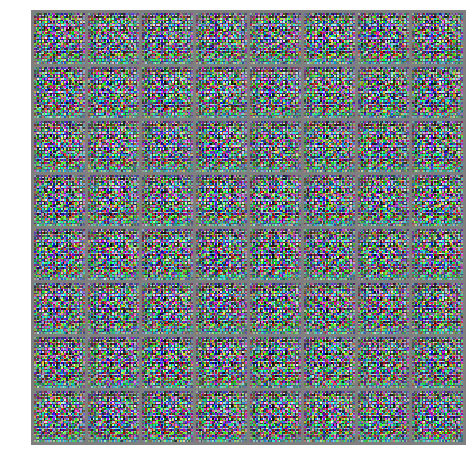

epoch: 1, iteration: 0, D_loss: 0.2822; G_loss: -3.308


<Figure size 432x288 with 0 Axes>

In [0]:
## Training
D_losses = []
G_losses = []


for epoch in range(100):
  d_loss = []
  g_loss = []
  for idx, (data,labels) in enumerate(trainloader):
    ## generator loss, discriminator loss
    x_sample  = data.to(device)
    z_sample = sample_Z(Params.mb_size, Z_dim)
    z_sample = torch.from_numpy(z_sample).to(device)
    
    ## Pass
    z_gen = generative_X2Y(x_sample)
    x_gen = generative_Y2X(z_sample)
    
    # discriminator
    fxz, Dxz = data_network(X, z_gen)
    fzx, Dzx = data_network(x_gen, z)
    
    ## total discriminator loss
    ## parameter update
    D_solver.zero_grad()
    loss = torch.mean(torch.log(Dzx) - torch.log(1- Dxz))
    loss.backward()
    D_solver.step()
    

    ## Generator Loss
    G_solver.zero_grad()
    
    ## Pass
    X_rec = generative_Y2X(z_gen)
    z_rec = generative_X2Y(x_gen)
    fxz, Dxz = data_network(X, z_gen)
    fzx, Dzx = data_network(x_gen, z)
    
    L_x = -torch.mean(fxz)
    L_z = torch.mean(fzx)

    ## Total Generator Loss
    X_rec_loss = torch.mean(torch.abs(X-X_rec))
    Z_rec_loss = torch.mean(torch.abs(z-z_rec)) 
    G_loss_curr = (L_x + L_z) + Params.lamb * X_rec_loss + Params.lamb * Z_rec_loss
    G_loss_curr.backward()
     
    G_solver.step()
    
    g_loss.append(G_loss_curr.item())
    d_loss.append(loss.item())
    
    ##
    if idx% 50 == 0:
      #torch.save(model.state_dict(), PATH)
      print("epoch: {}, iteration: {}, D_loss: {:.4}; G_loss: {:.4}".format(epoch, idx, D_loss_curr.item(), G_loss_curr.item()))
      
      ## test generated samples
      zz = sample_Z(Params.mb_size, Z_dim)
      zz_sample = torch.from_numpy(zz).to(device)
      
      ## generated z
      A =  generative_Y2X(zz_sample)
      #imshow(torchvision.utils.make_grid(A.detach().cpu()))
      #plt.savefig("./logs/gen_{}_{}.png".format(str(idx).zfill(3),epoch), bbox_inches = 'tight')
      #plt.close(fig)
                
      imshow(torchvision.utils.make_grid(X_rec.detach.cpu()))
      plt.show()
      
    
  D_losses.append(np.mean(d_loss))
  G_losses.append(np.mean(g_loss))
  
  
    